# TM10007 Assignment template -- ECG data

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [4]:
# General packages
import zipfile
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV, learning_curve
from sklearn.metrics import RocCurveDisplay, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
import sklearn.metrics
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

# Classifiers
from sklearn.ensemble import RandomForestClassifier

with zipfile.ZipFile(os.path.join('tm10007_ml','ecg','ecg_data.zip'), 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 827
The number of columns: 9001


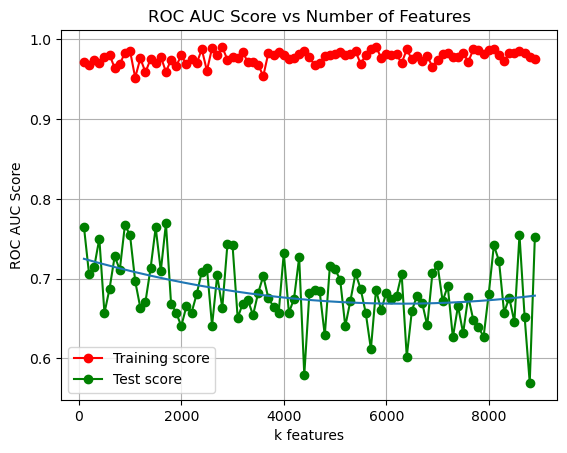

In [5]:
# Deze code maakt een grafiek waarin met een simpele random forest verschillende aantal features plot voor een train-test-split
# om zo te kijken hoeveel features we ongeveer willen selecteren voor het echte model

labels = data.iloc[:,-1]
x = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=42)

train_scores = []
test_scores = []
k_list = np.arange(100,9000,100)
for k in k_list:
    rf = Pipeline([('feature_selection', SelectKBest(f_classif, k=k)), ('rfc', RandomForestClassifier(n_estimators=10, max_depth=5, n_jobs=-1, random_state=42))])
    rf.fit(X_train, y_train)
    train_scores.append(roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]))
    test_scores.append(roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

poly = np.polyfit(k_list, test_scores, deg=2)
poly_func = np.poly1d(poly)

k_smooth = np.linspace(k_list.min(), k_list.max(), 300)
test_scores_smooth = poly_func(k_smooth)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid()
ax.plot(k_list, train_scores, 'o-', color="r",
        label="Training score")
ax.plot(k_list, test_scores, 'o-', color="g",
        label="Test score")
ax.plot(k_smooth, test_scores_smooth)
ax.set_title('ROC AUC Score vs Number of Features')
ax.set_xlabel('k features')
ax.set_ylabel('ROC AUC Score')
ax.legend()


In [6]:
def plot_learning_curve(X_train, y_train, classifier, scoring, clf_type):
    if scoring == 'error':
        train_sizes, train_scores, test_scores = learning_curve(
            classifier,
            X_train,
            y_train,
            cv=StratifiedKFold(n_splits=5),
            scoring='accuracy',
            train_sizes=np.linspace(0.1, 1.0, 50),
            n_jobs=-1
        )
        train_scores_mean = 1-np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = 1-np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
    else:
        train_sizes, train_scores, test_scores = learning_curve(
            classifier,
            X_train,
            y_train,
            cv=StratifiedKFold(n_splits=5),
            scoring=scoring,
            train_sizes=np.linspace(0.1, 1.0, 50),
            n_jobs=-1
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(f"Learning Curve ({clf_type})")
    plt.xlabel("Number of training objects")
    plt.ylabel(scoring)

    plt.grid()

    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score", color="blue")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="blue")

    plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score", color="green")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="green")

    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

def optimize_rf(X_train, y_train):
    pipe = Pipeline([('feature_selection', SelectKBest(f_classif)), 
                 ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, max_features='sqrt', class_weight='balanced'))
                 ])

    param_dist = {
        'feature_selection__k': np.arange(50, 250, 10),
        'classifier__n_estimators': np.arange(5, 15, 5),
        'classifier__min_samples_split': np.arange(20, 50, 5),
        'classifier__min_samples_leaf': np.arange(20, 50, 5),
        'classifier__max_depth': [5, 10],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__bootstrap': [True, False]
    }

    n_iterations = 20

    random_search = RandomizedSearchCV(
                                        pipe, 
                                        param_distributions=param_dist, 
                                        cv=StratifiedKFold(n_splits=5), 
                                        n_iter=n_iterations,
                                        scoring='roc_auc', 
                                        n_jobs=-1
                                        )
    random_search.fit(X_train, y_train)

    print("Best Parameters:", random_search.best_params_)
    print("Best Score:", random_search.best_score_)
    return random_search.best_estimator_

def plot_roc_cv(X, y, n_splits=5):
    y = data.iloc[:,-1]
    X = data.iloc[:,:-1]

    cv = StratifiedKFold(n_splits=n_splits)

    tprs = []
    aucs = []
    best_classifier = None
    best_auc = 0.0
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(6, 6))
    for fold, (train, test) in enumerate(cv.split(X, y)):
        X_train = X.iloc[train]
        y_train = y.iloc[train]
        X_test = X.iloc[test]
        y_test = y.iloc[test]
        classifier = optimize_rf(X_train, y_train)
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X_test,
            y_test,
            name=f"ROC fold {fold}",
            alpha=0.3,
            lw=1,
            ax=ax,
            plot_chance_level=(fold == n_splits - 1),
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        if viz.roc_auc > best_auc:
            best_auc = viz.roc_auc
            best_classifier = classifier
            best_X_train = X_train
            best_y_train = y_train

        y_pred = classifier.predict(X_test)
        y_proba = classifier.predict_proba(X_test)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        fold_auc = roc_auc_score(y_test, y_proba)

        print(f"Accuracy:  {accuracy:.3f}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall:    {recall:.3f}")
        print(f"F1 Score:  {f1:.3f}")
        print(f"AUC Score: {fold_auc:.3f}")

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = sklearn.metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve with variability",
    )
    ax.legend(loc="lower right")
    plt.show()
    return best_X_train, best_y_train, best_classifier


Best Parameters: {'feature_selection__k': 80, 'classifier__n_estimators': 5, 'classifier__min_samples_split': 40, 'classifier__min_samples_leaf': 25, 'classifier__max_depth': 5, 'classifier__criterion': 'entropy', 'classifier__bootstrap': True}
Best Score: 0.7665584203735714
Accuracy:  0.807
Precision: 0.462
Recall:    0.621
F1 Score:  0.529
AUC Score: 0.801
Best Parameters: {'feature_selection__k': 130, 'classifier__n_estimators': 10, 'classifier__min_samples_split': 45, 'classifier__min_samples_leaf': 20, 'classifier__max_depth': 5, 'classifier__criterion': 'entropy', 'classifier__bootstrap': False}
Best Score: 0.812006382130036
Accuracy:  0.801
Precision: 0.457
Recall:    0.533
F1 Score:  0.492
AUC Score: 0.748
Best Parameters: {'feature_selection__k': 140, 'classifier__n_estimators': 10, 'classifier__min_samples_split': 25, 'classifier__min_samples_leaf': 30, 'classifier__max_depth': 5, 'classifier__criterion': 'entropy', 'classifier__bootstrap': False}
Best Score: 0.77007711740460

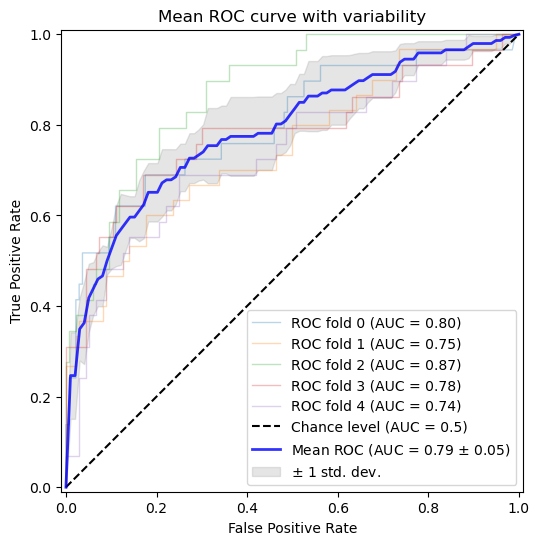

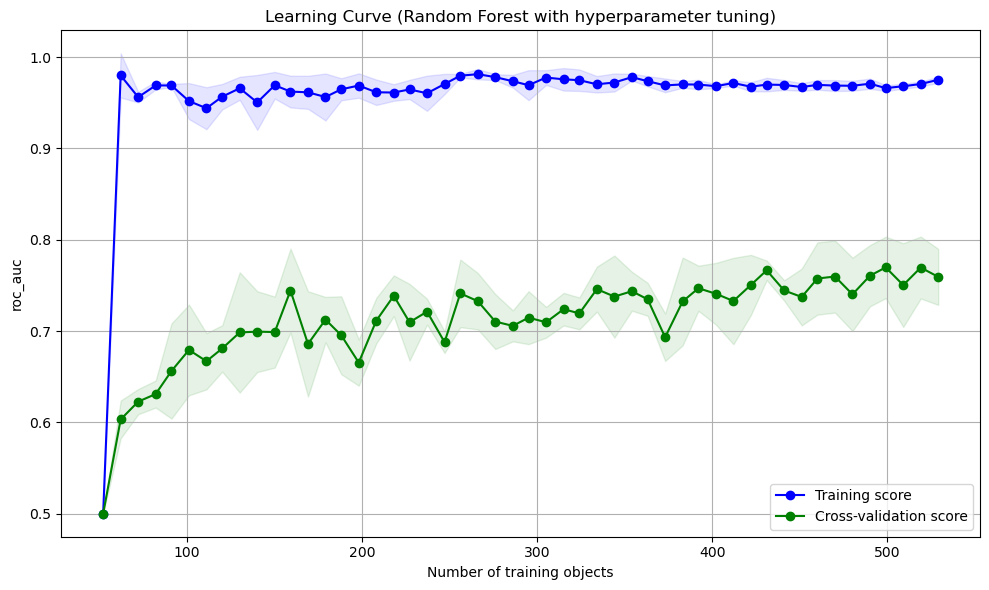

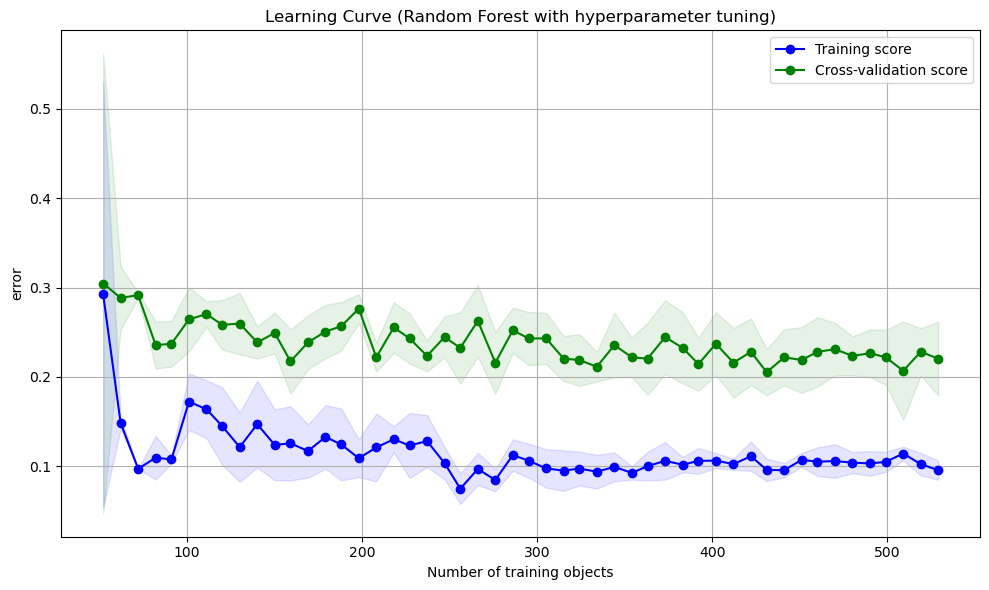

In [ ]:
random_state = np.random.RandomState(0)

X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X_train, y_train, best_classifier = plot_roc_cv(X, y, n_splits=5)
plot_learning_curve(X_train, y_train, best_classifier, scoring='roc_auc', clf_type='Random Forest with hyperparameter tuning')
plot_learning_curve(X_train, y_train, best_classifier, scoring='error', clf_type='Random Forest with hyperparameter tuning')


# Unused

# Baseline RandomForest model
To check the performance of a simple model, a RandomForestClassifier with 10 estimators and a max depth of 5 was used. The same model was used to plot the AUC score vs the number of features.

The learning curve shows that the addition of more samples does not significantly change the training error after around 400 samples. The cross-validation score barely decreases when adding more samples, indicating that the model is overfit.

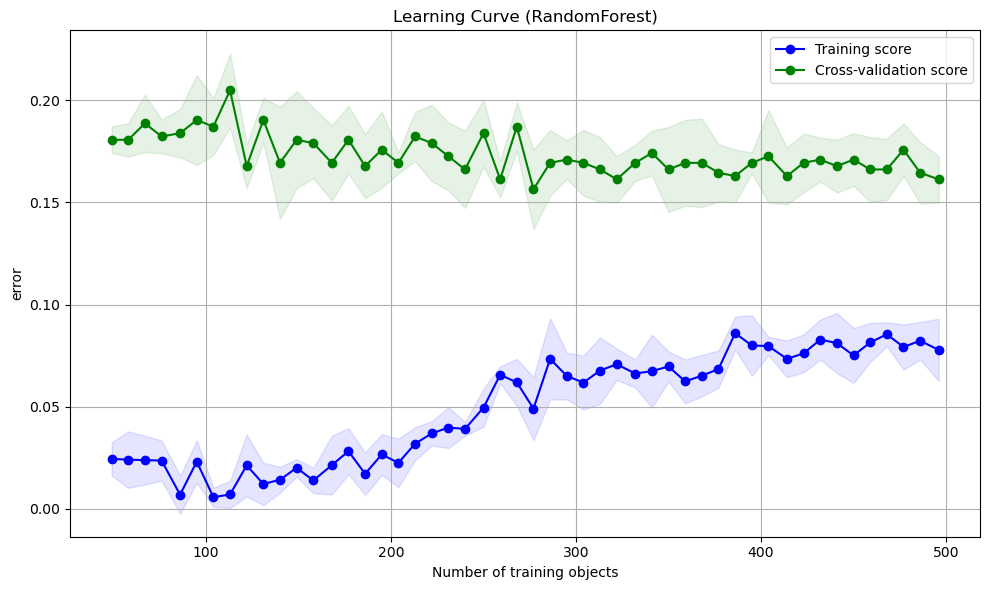

In [65]:
labels = data.iloc[:,-1]
x = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=42)

rf = RandomForestClassifier(n_estimators=10, max_depth=5, n_jobs=-1)
rf.fit(X_train, y_train)

plot_learning_curve(X_train, y_train, rf, scoring='error', clf_type='RandomForest')

Best Parameters: {'feature_selection__k': 125, 'classifier__n_estimators': 30, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 14, 'classifier__max_depth': 16, 'classifier__criterion': 'gini', 'classifier__bootstrap': False}
Best Score: 0.7936484940930826
Accuracy:  0.880
Precision: 0.667
Recall:    0.621
F1 Score:  0.643
AUC Score: 0.810
Best Parameters: {'feature_selection__k': 925, 'classifier__n_estimators': 20, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 16, 'classifier__max_depth': 10, 'classifier__criterion': 'gini', 'classifier__bootstrap': False}
Best Score: 0.814745379603776
Accuracy:  0.813
Precision: 0.474
Recall:    0.300
F1 Score:  0.367
AUC Score: 0.743
Best Parameters: {'feature_selection__k': 375, 'classifier__n_estimators': 24, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 12, 'classifier__max_depth': 16, 'classifier__criterion': 'entropy', 'classifier__bootstrap': False}
Best Score: 0.78002260337721

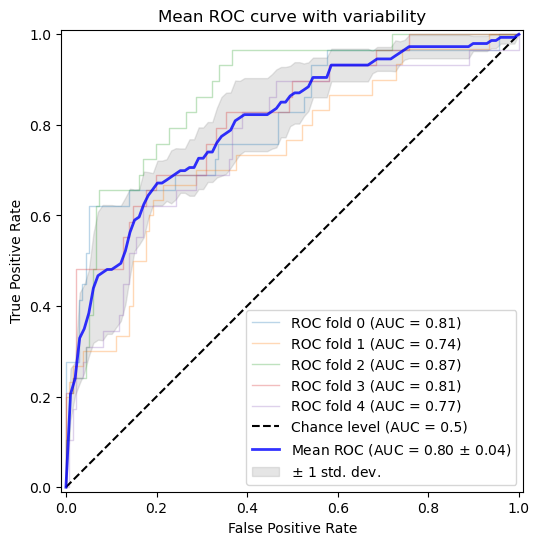

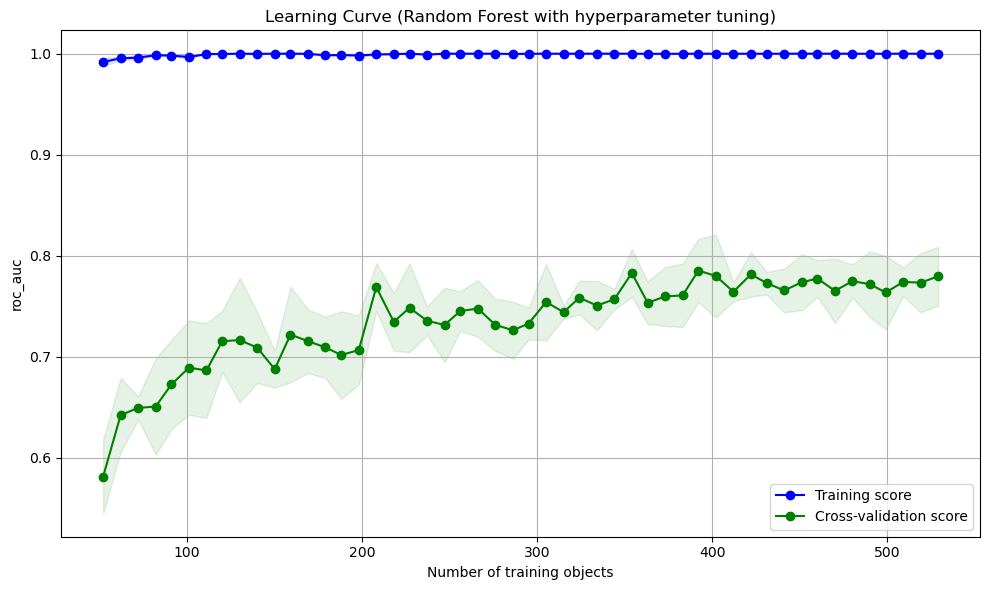

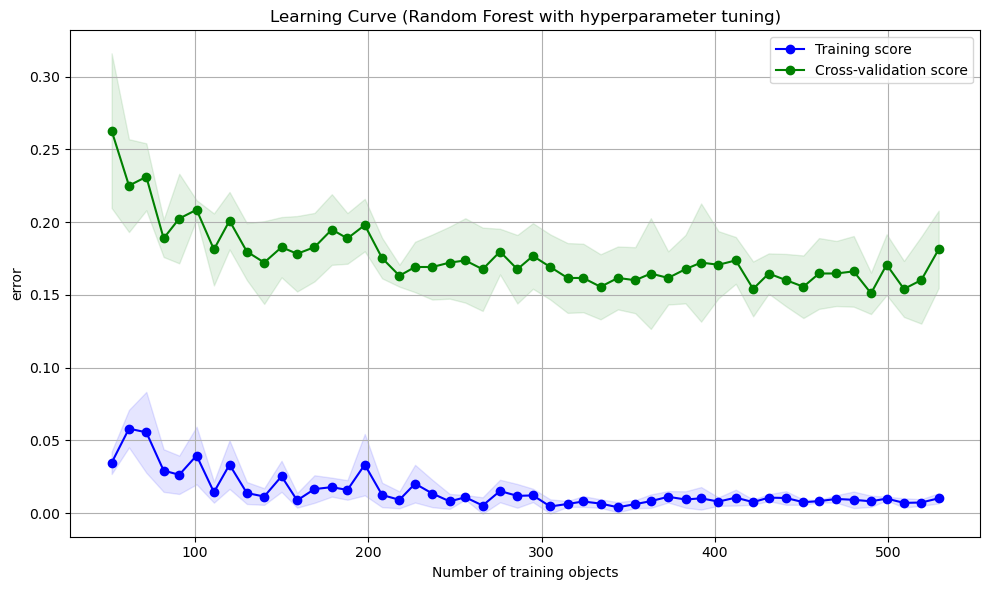

In [7]:
def optimize_rf(X_train, y_train):
    pipe = Pipeline([('feature_selection', SelectKBest(f_classif)), 
                 ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, max_features='sqrt', class_weight='balanced'))
                 ])

    param_dist = {
        'feature_selection__k': np.arange(100, 2500, 25), # [300, 400, 500, 9000],
        'classifier__n_estimators': np.arange(10, 40, 2), # [30, 40, 50],
        'classifier__min_samples_split': np.arange(10, 20, 2), # [5, 10, 15],
        'classifier__min_samples_leaf': np.arange(10, 20, 2),
        'classifier__max_depth': np.arange(6, 20, 2), # [5, 10, 15, None],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__bootstrap': [True, False]
    }

    n_iterations = 20

    random_search = RandomizedSearchCV(
                                        pipe, 
                                        param_distributions=param_dist, 
                                        cv=StratifiedKFold(n_splits=5), 
                                        n_iter=n_iterations,
                                        scoring='roc_auc', 
                                        n_jobs=-1
                                        )
    random_search.fit(X_train, y_train)

    print("Best Parameters:", random_search.best_params_)
    print("Best Score:", random_search.best_score_)
    return random_search.best_estimator_

random_state = np.random.RandomState(0)

X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X_train, y_train, best_classifier = plot_roc_cv(X, y, n_splits=5)
plot_learning_curve(X_train, y_train, best_classifier, scoring='roc_auc', clf_type='Random Forest with hyperparameter tuning')
plot_learning_curve(X_train, y_train, best_classifier, scoring='error', clf_type='Random Forest with hyperparameter tuning')


Best Parameters: {'feature_selection__k': 850, 'classifier__n_estimators': 15, 'classifier__min_samples_split': 35, 'classifier__min_samples_leaf': 45, 'classifier__max_depth': 5, 'classifier__criterion': 'gini', 'classifier__bootstrap': False}
Best Score: 0.7798401512801194
Accuracy:  0.801
Precision: 0.447
Recall:    0.586
F1 Score:  0.507
AUC Score: 0.787
Best Parameters: {'feature_selection__k': 950, 'classifier__n_estimators': 15, 'classifier__min_samples_split': 35, 'classifier__min_samples_leaf': 45, 'classifier__max_depth': 10, 'classifier__criterion': 'entropy', 'classifier__bootstrap': True}
Best Score: 0.8092308203696316
Accuracy:  0.753
Precision: 0.296
Recall:    0.267
F1 Score:  0.281
AUC Score: 0.670
Best Parameters: {'feature_selection__k': 200, 'classifier__n_estimators': 10, 'classifier__min_samples_split': 40, 'classifier__min_samples_leaf': 20, 'classifier__max_depth': 5, 'classifier__criterion': 'entropy', 'classifier__bootstrap': False}
Best Score: 0.7565383592607

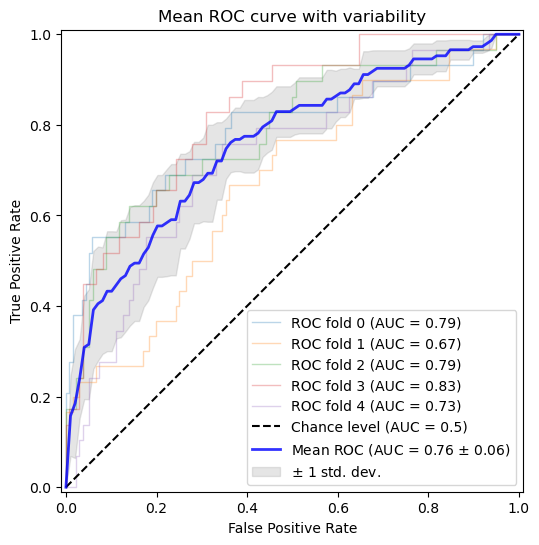

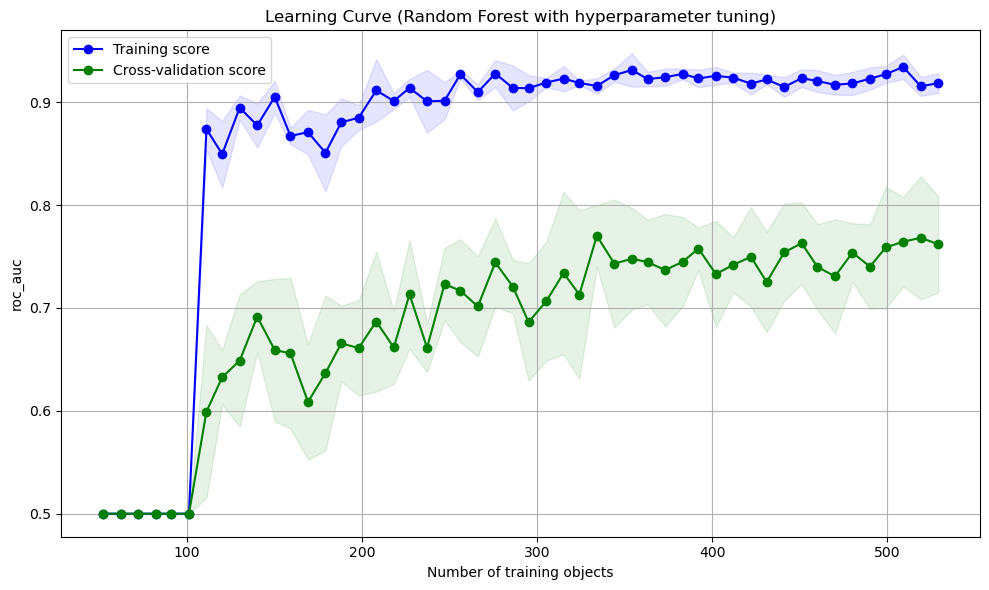

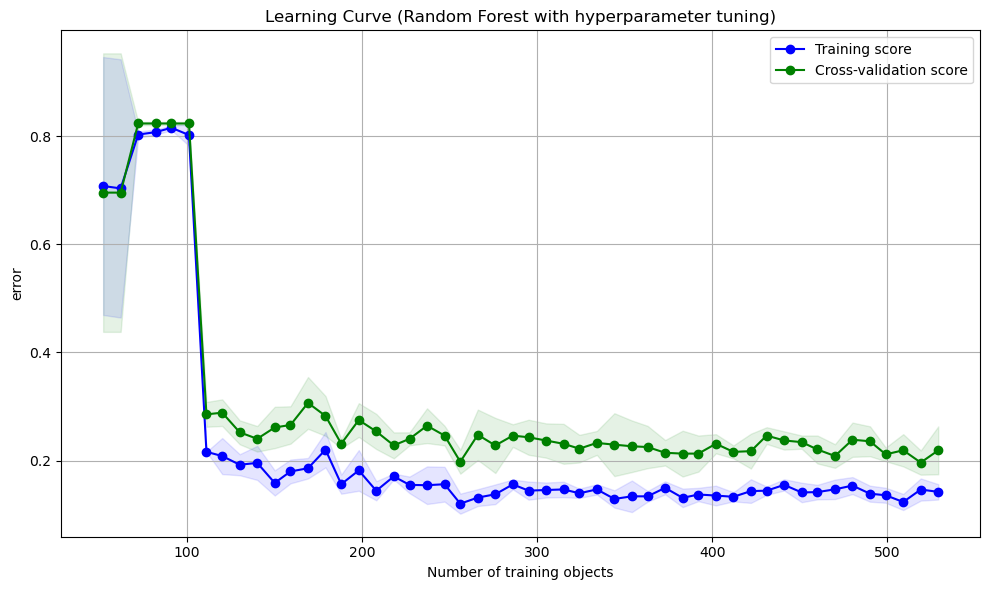

In [8]:
def optimize_rf(X_train, y_train):
    pipe = Pipeline([('feature_selection', SelectKBest(f_classif)), 
                 ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, max_features='sqrt', class_weight='balanced'))
                 ])

    param_dist = {
        'feature_selection__k': np.arange(100, 1000, 50),
        'classifier__n_estimators': np.arange(5, 20, 5),
        'classifier__min_samples_split': np.arange(20, 50, 5),
        'classifier__min_samples_leaf': np.arange(20, 50, 5),
        'classifier__max_depth': [5, 10],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__bootstrap': [True, False]
    }

    n_iterations = 20

    random_search = RandomizedSearchCV(
                                        pipe, 
                                        param_distributions=param_dist, 
                                        cv=StratifiedKFold(n_splits=5), 
                                        n_iter=n_iterations,
                                        scoring='roc_auc', 
                                        n_jobs=-1
                                        )
    random_search.fit(X_train, y_train)

    print("Best Parameters:", random_search.best_params_)
    print("Best Score:", random_search.best_score_)
    return random_search.best_estimator_

random_state = np.random.RandomState(0)

X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X_train, y_train, best_classifier = plot_roc_cv(X, y, n_splits=5)
plot_learning_curve(X_train, y_train, best_classifier, scoring='roc_auc', clf_type='Random Forest with hyperparameter tuning')
plot_learning_curve(X_train, y_train, best_classifier, scoring='error', clf_type='Random Forest with hyperparameter tuning')

Best Parameters: {'feature_selection__k': 110, 'classifier__n_estimators': 15, 'classifier__min_samples_split': 40, 'classifier__min_samples_leaf': 45, 'classifier__min_impurity_decrease': 0.001, 'classifier__max_depth': 10, 'classifier__criterion': 'entropy', 'classifier__bootstrap': False}
Best Score: 0.7756461845105309
Accuracy:  0.753
Precision: 0.364
Recall:    0.552
F1 Score:  0.438
AUC Score: 0.781
Best Parameters: {'feature_selection__k': 120, 'classifier__n_estimators': 15, 'classifier__min_samples_split': 35, 'classifier__min_samples_leaf': 30, 'classifier__min_impurity_decrease': 0.0001, 'classifier__max_depth': 10, 'classifier__criterion': 'gini', 'classifier__bootstrap': True}
Best Score: 0.8073095333067413
Accuracy:  0.765
Precision: 0.378
Recall:    0.467
F1 Score:  0.418
AUC Score: 0.720
Best Parameters: {'feature_selection__k': 130, 'classifier__n_estimators': 10, 'classifier__min_samples_split': 20, 'classifier__min_samples_leaf': 35, 'classifier__min_impurity_decreas

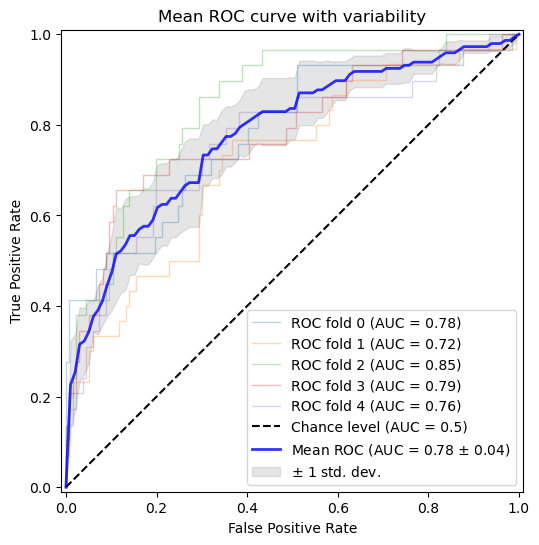

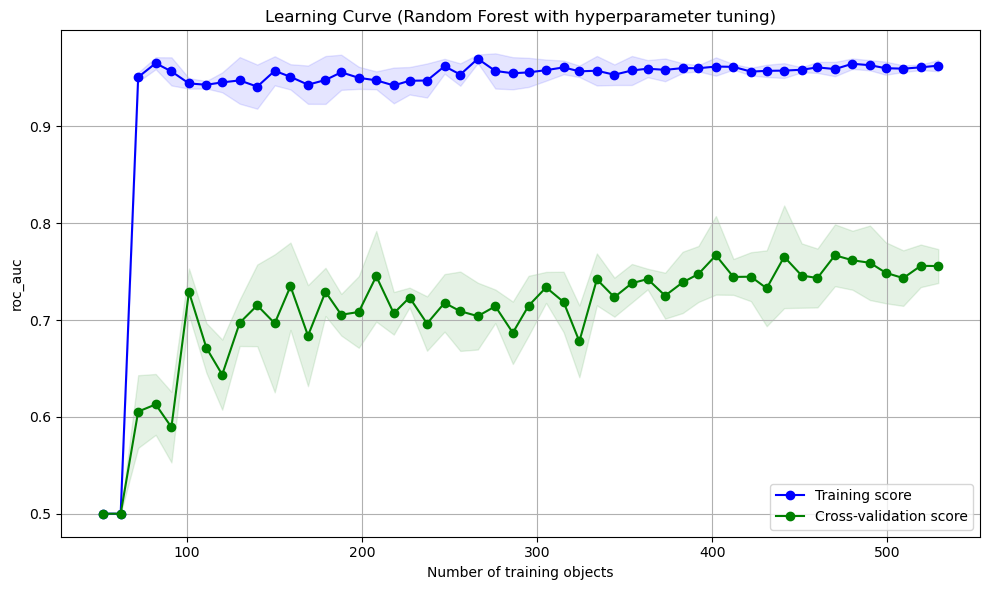

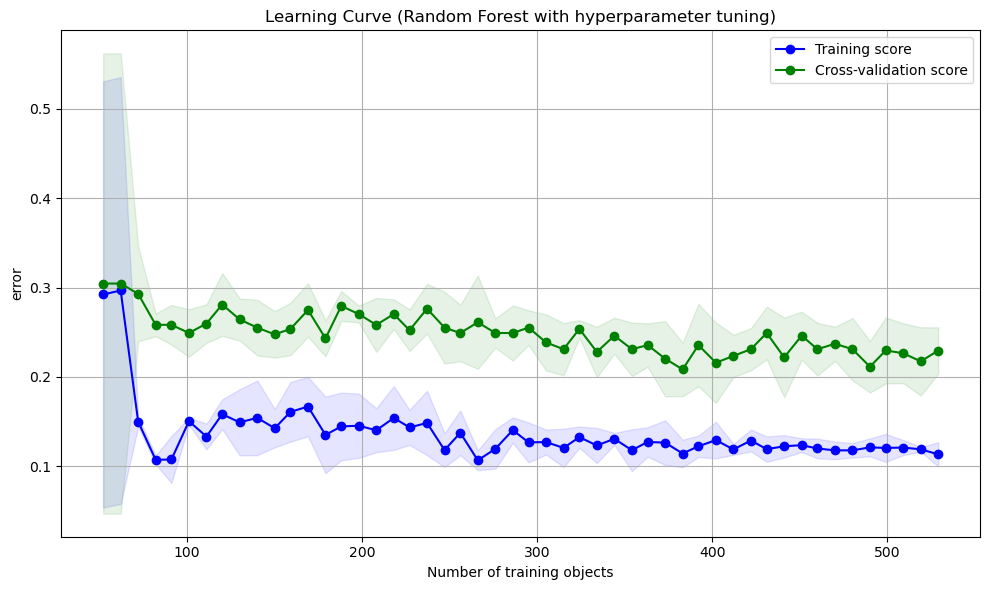

In [ ]:
def optimize_rf(X_train, y_train):
    pipe = Pipeline([('feature_selection', SelectKBest(f_classif)), 
                 ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1, max_features='sqrt', class_weight='balanced'))
                 ])

    param_dist = {
        'feature_selection__k': np.arange(50, 250, 10),
        'classifier__n_estimators': np.arange(5, 20, 5),
        'classifier__min_samples_split': np.arange(20, 50, 5),
        'classifier__min_samples_leaf': np.arange(20, 50, 5),
        'classifier__max_depth': [5, 10],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__bootstrap': [True, False],
        'classifier__min_impurity_decrease': [0.0001, 0.001, 0.01, 0.1]
    }

    n_iterations = 20

    random_search = RandomizedSearchCV(
                                        pipe, 
                                        param_distributions=param_dist, 
                                        cv=StratifiedKFold(n_splits=5), 
                                        n_iter=n_iterations,
                                        scoring='roc_auc', 
                                        n_jobs=-1
                                        )
    random_search.fit(X_train, y_train)

    print("Best Parameters:", random_search.best_params_)
    print("Best Score:", random_search.best_score_)
    return random_search.best_estimator_

random_state = np.random.RandomState(0)

X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X_train, y_train, best_classifier = plot_roc_cv(X, y, n_splits=5)
plot_learning_curve(X_train, y_train, best_classifier, scoring='roc_auc', clf_type='Random Forest with hyperparameter tuning')
plot_learning_curve(X_train, y_train, best_classifier, scoring='error', clf_type='Random Forest with hyperparameter tuning')